In [1]:
%matplotlib inline
import numpy as np
import sys
import scipy
sys.path.append('../datasets')
sys.path.append('../optimization')
sys.path.append('../util')
import eval as E
from eval import compute_weighted_loss, compute_loss_k

import compute_quantities as CQ
import find_z as FZ

In [485]:
import sentiment_analysis as SA
reload(SA)
datadir = '/data/sentiment_analysis2/domain_adaptation/'
sp = 2
mO = 16
ng = 1
domains=('kitchen', 'dvd', 'books', 'electronics')
src_ind = [1,2]
tgt_ind = [0,3]
src_dom = [d for i,d in enumerate(domains) if i in src_ind]
DP = SA.sm_problem(datadir=datadir, minO=mO, ngram=ng, 
                split=sp, sources=src_dom, dset='train')
DP_te = SA.sm_problem(datadir=datadir, minO=mO, ngram=ng, 
                split=sp, sources=domains,dset='test')
DP_te.subsample(src_ind, tgt_ind)
print DP.eta, src_dom

1e-100 ['dvd', 'books']


In [486]:
import problem as P
reload(P)
prob = P.ConvexConcaveProblem(DP)
solver = P.ConvexConcaveSolver(prob)

In [487]:
z = z_iter[:,-1]
u = compute_u(z, DP)
u2 = prob.compute_convex(z)

print u - u2
v = compute_v(z, DP)
v2 = prob.compute_concave(z)
print v - v2

gv = CQ.compute_gv_new(z, DP)
gv2 = prob.compute_grad_concave(z)
print gv - gv2

gu = CQ.compute_gu_new(z, DP)
gu2 = prob.compute_grad_convex(z)
print gu - gu2

[ 0.  0.]
[ 0.  0.]
[[  4.03896783e-27  -6.77626358e-21]
 [  0.00000000e+00   1.62630326e-19]]
[[  3.23117427e-27   2.58493941e-26]
 [  6.46234854e-27   3.25260652e-19]]


In [488]:
z_iter,o_iter,err_iter = solver.solve()

Iter 0: obj val=1.057e-07  err val=1.127
Iter 10: obj val=1.057e-07  err val=1.127
Iter 20: obj val=1.057e-07  err val=1.127
Iter 30: obj val=1.056e-07  err val=1.127
Iter 40: obj val=1.056e-07  err val=1.127
Iter 50: obj val=1.056e-07  err val=1.127
Iter 60: obj val=1.056e-07  err val=1.127
Iter 70: obj val=1.055e-07  err val=1.127
Iter 80: obj val=1.055e-07  err val=1.127
Iter 90: obj val=1.055e-07  err val=1.127
Iter 100: obj val=1.055e-07  err val=1.127


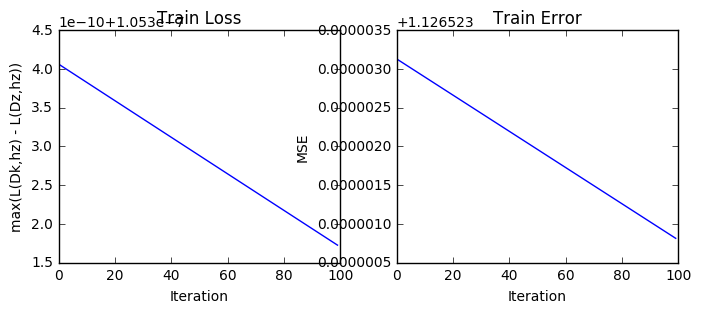

In [489]:
fig = plt.figure(figsize=[8,3])
ax = fig.add_subplot(121)
ax.plot(range(len(o_iter)), o_iter)
plt.title('Train Loss')
plt.xlabel('Iteration')
plt.ylabel('max(L(Dk,hz) - L(Dz,hz))')

ax2 = fig.add_subplot(122)
ax2.plot(range(len(err_iter)), err_iter)
plt.title('Train Error')
plt.xlabel('Iteration')
plt.ylabel('MSE')

In [491]:
z_iter[:,-1]

array([ 0.00471803,  0.9952842 ])

In [95]:
def compute_DzJzKz(z, DP):
    D = DP.get_marginal_density()
    h = DP.get_regressor()
    y = DP.get_true_values()
    
    Dh = D*h
    etaU = DP.eta * DP.U
    H = DP.get_H()

    z_mat = np.tile(z.transpose(), [D.shape[0],1])
    zDh = z_mat*Dh
    Dz = (z_mat*D).sum(axis=1)
    Kz = Dz + etaU
    
    Jz = zDh.sum(axis=1) + etaU*H
    return Dz, Kz, Jz

def compute_Jz_old(x, z, DP):
    H = DP.get_H()
    etaU = DP.eta*DP.U
    const = etaU * H[x]
    D = DP.get_marginal_density()[x,:]
    h = DP.get_regressor()[x,:]
    Dh = D*h
    zDh = 0
    for k in range(DP.p):
        zDh += z[k] * (D[k] * h[k])
    return zDh + const

In [231]:
def compute_u(z, DP):
    D = DP.get_marginal_density()
    h = DP.get_regressor()
    y = DP.get_true_values()
    
    Dh = D*h
    etaU = DP.eta * DP.U
    H = DP.get_H()

    z_mat = np.tile(z.transpose(), [D.shape[0],1])
    zDh = z_mat*Dh
    Dz = (z_mat*D).sum(axis=1)
    Jz = zDh.sum(axis=1) + etaU*H
    Kz = Dz + etaU
    hz = Jz / Kz

    err = (hz-y)**2
    v0 = err - 2*DP.M*np.log(Kz)
    
    u = np.zeros(DP.p)
    for k in range(DP.p):
        u[k] = ((D[:,k]+etaU) * v0).sum()
        
    return u

def compute_v(z, DP):
    D = DP.get_marginal_density()
    h = DP.get_regressor()
    y = DP.get_true_values()
    
    Dh = D*h
    etaU = DP.eta * DP.U
    H = DP.get_H()

    z_mat = np.tile(z.transpose(), [D.shape[0],1])
    zDh = z_mat*Dh
    Dz = (z_mat*D).sum(axis=1)
    Jz = zDh.sum(axis=1) + etaU*H
    Kz = Dz + etaU
    hz = Jz / Kz

    err = (hz-y)**2
    v0 = (- 2*DP.M*np.log(Kz))
    v1 = Kz * err
    v = np.zeros(DP.p)
    for k in range(DP.p):
        v[k] = ((D[:,k]+etaU) * v0 + v1).sum()
    return v
    

def compute_hz(z, DP):
    D = DP.get_marginal_density()
    h = DP.get_regressor()
    Dh = D*h
    etaU = DP.eta * DP.U
    H = h.sum(axis=1)/DP.p

    z_mat = np.tile(z.transpose(), [D.shape[0],1])
    zDh = z_mat*Dh
    Dz = (z_mat*D).sum(axis=1)
    Jz = zDh.sum(axis=1) + etaU*H
    Kz = Dz + etaU
    hz = Jz / Kz
    return hz


def compute_sq_err(z, DP):
    hz = compute_hz(z,DP)
    y = DP.get_true_values()
    err = E.sq_loss(hz,y)
    return err

def compute_LDzhz(z, DP, ind=None):
    err = compute_sq_err(z, DP)
    D = DP.get_marginal_density()
    z_mat = np.tile(z.transpose(), [D.shape[0],1])
    Dz = (z_mat*D).sum(axis=1)
    return (Dz*err).sum()

def compute_LDkhz(k, z, DP, ind=None):
    err = compute_sq_err(z, DP)
    Dk = DP.get_marginal_density()[:,k]
    return (Dk*err).sum()


In [232]:
def global_obj(z, DP):
    #u = CQ.compute_u_new(z, DP)
    u = compute_u(z, DP)
    #v = CQ.compute_v_new(z, DP)
    v = compute_v(z, DP)
    return u - v

def obj_gradient(z, DP):
    gu = CQ.compute_gu_new(z, DP)
    gv = CQ.compute_gv_new(z, DP)
    return gu - gv

def linearized_obj(zt, vt, gvt, z, DP):
    #u = CQ.compute_u_new(z, DP)
    u = compute_u(z, DP)
    #vt = CQ.compute_v_new(zt, DP)
    #gvt = CQ.compute_gv_new(z, DP)
    return (u - vt)[:,np.newaxis] - np.array(gvt * (z-zt))

def linearized_obj_gradient(gvt, z, DP):
    gu = CQ.compute_gu_new(z, DP)
#    gvt = CQ.compute_gv_new(zt, DP)
    return gu - gvt

In [233]:
def project_onto_simplex(z):
    z[z<0] = 0 # clip negative values
    return z / z.sum() 

def choose_z0(DP, n=10):
    z_vals = np.zeros((DP.p,n))
    o_vals = np.zeros(n)
    for i in range(n):
        z = np.random.rand(DP.p)
        z /= z.sum()
        z_vals[:,i] = z
        o_vals[i] = max(global_obj(z, DP))
    k = np.argmin(o_vals)
    return z_vals[:,k]
        

def solve_iter(z0, DP, max_iter=2, delta=0.01, disp=False):
    g_obj = global_obj(z0, DP)
    k = np.argmax(g_obj)
    
    z = z0
    vt = compute_v(z0, DP)
    gvt = CQ.compute_gv_new(z0, DP)
    o_values = np.zeros(max_iter+1)
    o_values[0] = linearized_obj(z0, vt, gvt, z, DP)[k]
    last_change = 0
    if disp:
        print '\tIter 0: objective val={:0.2g}'.format(o_values[0])
    for it in range(1,max_iter+1):
        zgrad = linearized_obj_gradient(gvt, z, DP)
        z_prev = z
        z -= delta * np.array(zgrad[k,:].transpose())
        z = project_onto_simplex(z)
        oi = linearized_obj(z0, vt, gvt, z, DP)
        if not (oi.argmax() == k):
            print 'switching k:', k, oi.argmax()
            k = oi.argmax()
        o_values[it] = oi[k]
        
        change = True
        if o_values[it] > o_values[it-1]: #obj increased
            z = z_prev
            if disp:
                print '\tOvershot obj ({:0.2g}): resetting z and lowering delta'.format(o_values[it])
            o_values[it] = o_values[it-1]
            delta = 0.1*delta
            change = False
        elif np.abs(o_values[it] - o_values[it-1]) < 1e-15:
            if disp:
                print '\tConverged: change in values less than threshold', o_values[it]-o_values[it-1]
            break
        elif o_values[it] < 1e-15:
            if disp:
                print '\tConverged: objective is less than threshold', o_values[it]
            break
            
        if change:
            last_change = it
        
        if it - last_change > 5:
            break
        if disp:
            print '\tIter {:d}: objective val={:0.2g}'.format(it, o_values[it])
        
    return z

In [333]:
import sentiment_analysis as SA
reload(SA)
datadir = '/data/sentiment_analysis2/domain_adaptation/'
sp = 1
mO = 16
ng = 1
domains=('kitchen', 'dvd', 'books', 'electronics')
src_ind = [1,2]
tgt_ind = [0,3]
src_dom = [d for i,d in enumerate(domains) if i in src_ind]
DP = SA.sm_problem(datadir=datadir, minO=mO, ngram=ng, 
                split=sp, sources=src_dom, dset='train')
DP_te = SA.sm_problem(datadir=datadir, minO=mO, ngram=ng, 
                split=sp, sources=domains,dset='test')
DP_te.subsample(src_ind, tgt_ind)
print DP.eta, src_dom

1e-20 ['dvd', 'books']


In [334]:
DP_te.sources

['kitchen', 'electronics']

In [335]:
np.random.seed(432432)
z0 = choose_z0(DP)[:,np.newaxis]
#z0 = np.repeat(1.0/DP.p, DP.p)[:,np.newaxis]

max_iter = 100
o = np.zeros(max_iter+1)
o_te = np.zeros(max_iter+1)
z = z0

print z.flatten()
o_init = max(global_obj(z,DP))
o_te[0] = max(global_obj(z,DP_te))
print 'Initial: objective val={:f}'.format(o_init)
o[0] = o_init
err_tr = np.zeros(max_iter+1)
err_tr[0] = compute_sq_err(z,DP).sum()
err_te = np.zeros(max_iter+1)
err_te[0] = compute_sq_err(z,DP_te).sum()
delta = 10
for it in range(1,max_iter+1):
    z_prev = z
    z = solve_iter(z, DP, max_iter=20, delta=delta, disp=False)
    o[it] = max(global_obj(z, DP))
    o_te[it] = max(global_obj(z, DP_te))
    err_tr[it] = compute_sq_err(z,DP).sum()
    err_te[it] = compute_sq_err(z,DP_te).sum()
    if it % 10 == 0:
        print 'Iter {:d}: objective val={:0.4g}'.format(it, o[it]), z.flatten()
    if o[it-1] < o[it]:
        z = z_prev
        o[it] = o[it-1]
        o_te[it] = o_te[it-1]
        err_tr[it] = err_tr[it-1]
        err_te[it] = err_te[it-1]
        delta = 0.5 * delta
        print '\t\t lowering delta to {:0.2g}'.format(delta)
    elif np.abs(o[it] - o[it-1]) < 1e-15:
        print 'Converged: change in values less than threshold', o[it] - o[it-1]
        break
    elif o[it] < 1e-15:
        print 'Converged: objective is less than threshold', o[it]
        break    

[ 0.02125179  0.97874821]
Initial: objective val=0.000000
Converged: change in values less than threshold -4.00355416476e-22


In [336]:
hk = DP.get_regressor()[:,0]
y = DP.get_true_values()
print ((hk-y)**2).sum()/DP.n

hz = compute_hz(z, DP)
print ((hz-y)**2).sum()/DP.n
print hz[:5]
print hk[:5]
print y[:5]

1.32393446272
0.985903089556
[ 1.97648   4.255035  3.058685  3.72046   2.002585]
[ 1.85602  3.50543  3.21397  3.71387  1.89986]
[ 1.  1.  4.  5.  2.]


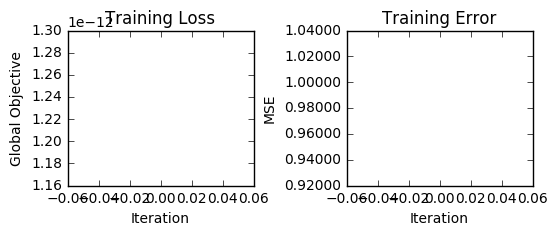

In [338]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

fig = plt.figure(figsize=[6,2])
fig.subplotpars.wspace = 0.5

fig.add_subplot(121)
plt.plot(range(it),o[:it])
plt.xlabel('Iteration')
plt.ylabel('Global Objective')
plt.title('Training Loss')

ax = fig.add_subplot(122)
plt.plot(range(it),err_tr[:it]/DP.n)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Training Error')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5f'))


In [341]:
m = np.arange(0, 1, 0.01)
loss_val_tr = np.zeros(len(m))
loss_val_te = np.zeros(len(m))
err_z_tr = np.zeros(len(m))
err_z_te = np.zeros(len(m))
y = DP.get_true_values()
y_te = DP_te.get_true_values()
for i,m_val in enumerate(m):
    zi = np.array([m_val, (1-m_val)])
    loss_val_tr[i] = max(global_obj(zi, DP))
    loss_val_te[i] = max(global_obj(zi, DP_te))
    hz_tr = compute_hz(zi, DP)
    hz_te = compute_hz(zi, DP_te)
    err_z_tr[i] = ((y - hz_tr)**2).sum() / DP.n
    err_z_te[i] = ((y_te - hz_te)**2).sum() / DP_te.n

Learned z value [ 0.02125179  0.97874821]
Best Train z [0.98999999999999999, 0.010000000000000009]
Best Test z 1.98915190918 [0.02, 0.97999999999999998]


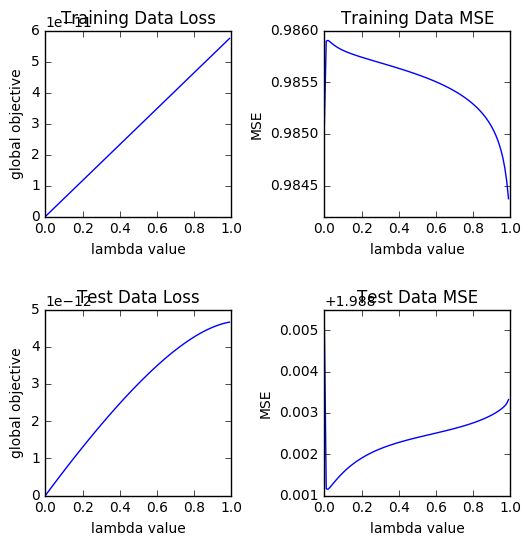

In [342]:
fig = plt.figure(figsize=[6,6])
fig.subplotpars.wspace = 0.5
fig.subplotpars.hspace = 0.5

ax = fig.add_subplot(221)
ax.plot(m, loss_val_tr)
plt.xlabel('lambda value')
plt.ylabel('global objective')
plt.title('Training Data Loss')

ax = fig.add_subplot(222)
ax.plot(m, err_z_tr)
plt.xlabel('lambda value')
plt.ylabel('MSE')
plt.title('Training Data MSE')

ax = fig.add_subplot(223)
ax.plot(m, loss_val_te)
plt.xlabel('lambda value')
plt.ylabel('global objective')
plt.title('Test Data Loss')

ax = fig.add_subplot(224)
ax.plot(m, err_z_te)
plt.xlabel('lambda value')
plt.ylabel('MSE')
plt.title('Test Data MSE')

print 'Learned z value', z.flatten()
print 'Best Train z', [m[err_z_tr.argmin()], (1-m[err_z_tr.argmin()])]
print 'Best Test z',err_z_te.min(), [m[err_z_te.argmin()], (1-m[err_z_te.argmin()])]

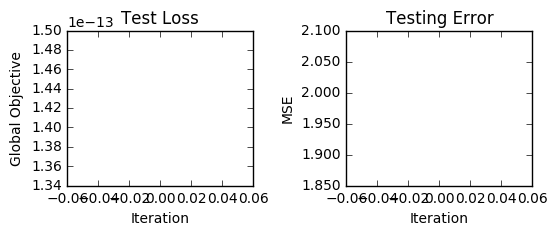

In [343]:
fig = plt.figure(figsize=[6,2])
fig.subplotpars.wspace = 0.5
fig.add_subplot(121)
plt.plot(range(it),o_te[:it])
plt.xlabel('Iteration')
plt.ylabel('Global Objective')
plt.title('Test Loss')

ax = fig.add_subplot(122)
plt.plot(range(it),err_te[:it] / DP_te.n)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Testing Error')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

In [344]:
DP_te.eta = 1e-20

In [492]:
def compute_sq_err_k(k,DP,src_ind=None):
    hk = DP.get_regressor()[:,k]
    y = DP.get_true_values()
    return (hk-y)**2

def compute_sq_err_cvx(z, DP):
    h = DP.get_regressor()
    z_mat = np.tile(z.transpose(), [h.shape[0],1])
    hz = (z_mat*h).sum(axis=1) 
    y = DP.get_true_values()
    return (hz-y)**2

z0 = np.repeat(1.0/DP.p, DP.p)
mse_tr = np.zeros([DP.p+1, DP.p+3])
mse_te = np.zeros([DP.p+1, DP.p+3])

for k in range(DP.p+1): # eval on k
    if k == DP.p:
        ind_tr = range(DP.n) # first three domains
        ind_te = range(DP_te.n) # first three domains
    elif k == DP.p+1:
        ind_tr = range(DP.n/DP.p, DP.n) # first three domains
        ind_te = range(DP_te.n/DP_te.p, DP_te.n) # first three domains
    else:   
        ind_tr = range(DP.n / DP.p * k, DP.n / DP.p * (k+1))
        ind_te = range(DP_te.n/DP.p * k, DP_te.n/DP.p * (k+1))
    for j in range(DP.p): # using j 
        mse_tr[k,j] = compute_sq_err_k(j, DP)[ind_tr].sum()/ len(ind_te)
        mse_te[k,j] = compute_sq_err_k(j, DP_te)[ind_te].sum()/ len(ind_te)
        
    mse_tr[k,DP.p] = compute_sq_err_cvx(z0, DP)[ind_tr].sum()/ len(ind_tr)
    mse_te[k,DP.p] = compute_sq_err_cvx(z0, DP_te)[ind_te].sum()/ len(ind_te)
    
    mse_tr[k,DP.p+1] = compute_sq_err(z0, DP)[ind_tr].sum()/ len(ind_tr)
    mse_te[k,DP.p+1] = compute_sq_err(z0, DP_te)[ind_te].sum()/ len(ind_te)
    
    mse_tr[k,DP.p+2] = compute_sq_err(z, DP)[ind_tr].sum()/ len(ind_tr)
    mse_te[k,DP.p+2] = compute_sq_err(z, DP_te)[ind_te].sum()/ len(ind_te)

In [493]:
print E.compute_weighted_loss(z, DP_te), compute_sq_err(z,DP_te).sum()/DP_te.n
print compute_sq_err_cvx(z, DP_te).sum()/DP_te.n
print compute_sq_err_cvx(z0, DP_te).sum()/DP_te.n, compute_sq_err(z0, DP_te).sum()/DP_te.n

2.07759696364 2.07759696364
2.29922597629
2.02370975672 2.07892455676


2


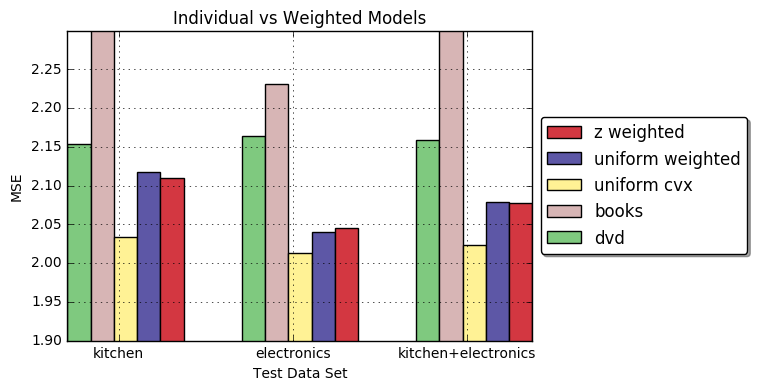

In [494]:
import matplotlib

cm = matplotlib.cm
#eta_old = DP_te.eta

#DP_te.eta = 100 * eta_old

fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid()

print DP.p
ne = DP.p+3
ind = np.array(range(ne))
width=1.5
tick_loc = np.zeros(ne)
for j in range(ne):
    if j < DP.p:
        l = DP.sources[j]
    elif j == DP.p+1:
        l = 'uniform weighted'
    elif j == DP.p+2:
        l = 'z weighted'
    elif j == DP.p:
        l = 'uniform cvx'
    ind_j = np.arange(ind[j],ne*width*(DP.p+1)+ind[j],ne*width)
    ax.bar(ind_j, mse_te[:,j].transpose(),
           width=1, label=l,color=cm.Accent(float(j)/ne))

ax.set_xticks(np.arange(ne/2+.2, ne*width*(DP.p+1)+ne/2+.2, ne*width))
label = list(DP_te.sources)
label.append('{:s}+{:s}'.format(DP_te.sources[0], DP_te.sources[1]))
label.append('dbe')
ax.set_xticklabels(label)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1] , loc='center left',
         bbox_to_anchor=(1.0, 0.5),fancybox=True, shadow=True)
ax.set_ylim([1.9,2.3])
plt.ylabel('MSE')
plt.xlabel('Test Data Set')
plt.title('Individual vs Weighted Models')

In [348]:
mse_te[-1,:]

array([ 2.1330049 ,  2.20564622,  1.99409703,  1.99040356,  1.98915634])

ValueError: incompatible sizes: argument 'height' must be length 2 or scalar

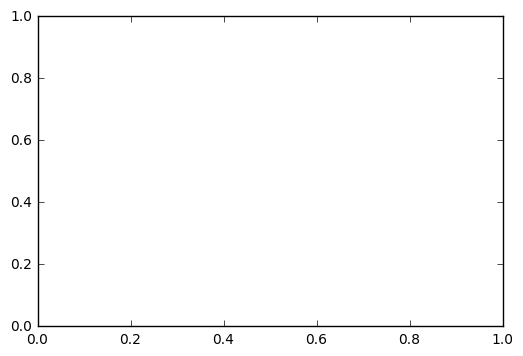

In [258]:
cm = matplotlib.cm

fig = plt.figure()
ax = fig.add_subplot(111)

ne = DP.p+2
ind = np.array(range(ne))
width=1.5
tick_loc = np.zeros(ne)
for j in range(ne):
    if j < DP.p:
        l = DP.sources[j]
    elif j == DP.p:
        l = 'uniform weighted'
    elif j == DP.p+1:
        l = 'z weighted'
    ind_j = np.arange(ind[j],ne*width*DP.p+ind[j],ne*width)
    ax.bar(ind_j, mse_tr[:,j].transpose(),
           width=1, label=l,color=cm.Accent(float(j)/ne))

ax.set_xticks(np.arange(ne/2+.2, (ne-1)*width*DP.p+ne/2+.2, ne*width))
ax.set_xticklabels(DP.sources)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1] , loc='center left',
         bbox_to_anchor=(1.0, 0.5),fancybox=True, shadow=True)
plt.ylabel('MSE')
plt.xlabel('Train Data Set')
plt.title('Individual vs Weighted Models')

In [259]:
mse_tr = np.zeros(DP.p+3)
mse_te = np.zeros(DP.p+3)
for j in range(DP.p): # using j 
    mse_tr[j] = compute_sq_err_k(j, DP).sum()/ DP.n
    mse_te[j] = compute_sq_err_k(j, DP_te).sum()/ DP_te.n

mse_tr[DP.p] = compute_sq_err_cvx(z0, DP).sum()/ DP.n
mse_te[DP.p] = compute_sq_err_cvx(z0, DP_te).sum()/ DP_te.n

mse_tr[DP.p+1] = compute_sq_err(z0, DP).sum()/ DP.n
mse_te[DP.p+1] = compute_sq_err(z0, DP_te).sum()/ DP_te.n

mse_tr[DP.p+2] = compute_sq_err(z, DP).sum()/ DP.n
mse_te[DP.p+2] = compute_sq_err(z, DP_te).sum()/ DP_te.n

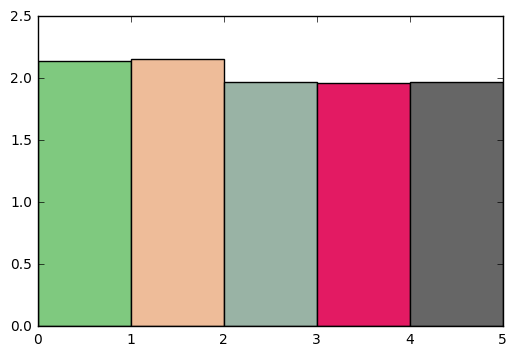

In [260]:
for j in range(len(mse_te)):
    plt.bar(j, mse_te[j],
            width=1, label=l,color=cm.Accent(float(j)/ne))